In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as cx

In [3]:
graduation = pd.read_csv('data/graduation.csv')
enrollment = pd.read_csv('data/enrollment.csv')

In [4]:
# Get cols of graduation
# Drop the rows where District is NYC SPEC SCHOOLS - DIST 75
graduation = graduation[graduation['District']!='NYC SPEC SCHOOLS - DIST 75']
# Drop the rows where Group!= All Students
graduation = graduation[graduation['Group']=='All Students']
graduation['graduation_Rate']=graduation['Graduates']/graduation['Total']

In [5]:
# Get the district number
graduation['district_num'] = graduation['District'].str.extract('(\d+)', expand=False)
# Get the last word of the district name
graduation['district_borough'] = graduation['District'].str.split().str[-1]
# Replace the island with Staten_Island
graduation['district_borough'] = graduation['district_borough'].replace('ISLAND','Staten Island')
graduation['district_borough'] = graduation['district_borough'].replace('BRONX','Bronx')
graduation['district_borough'] = graduation['district_borough'].replace('BROOKLYN','Brooklyn')
graduation['district_borough'] = graduation['district_borough'].replace('MANHATTAN','Manhattan')
graduation['district_borough'] = graduation['district_borough'].replace('QUEENS','Queens')

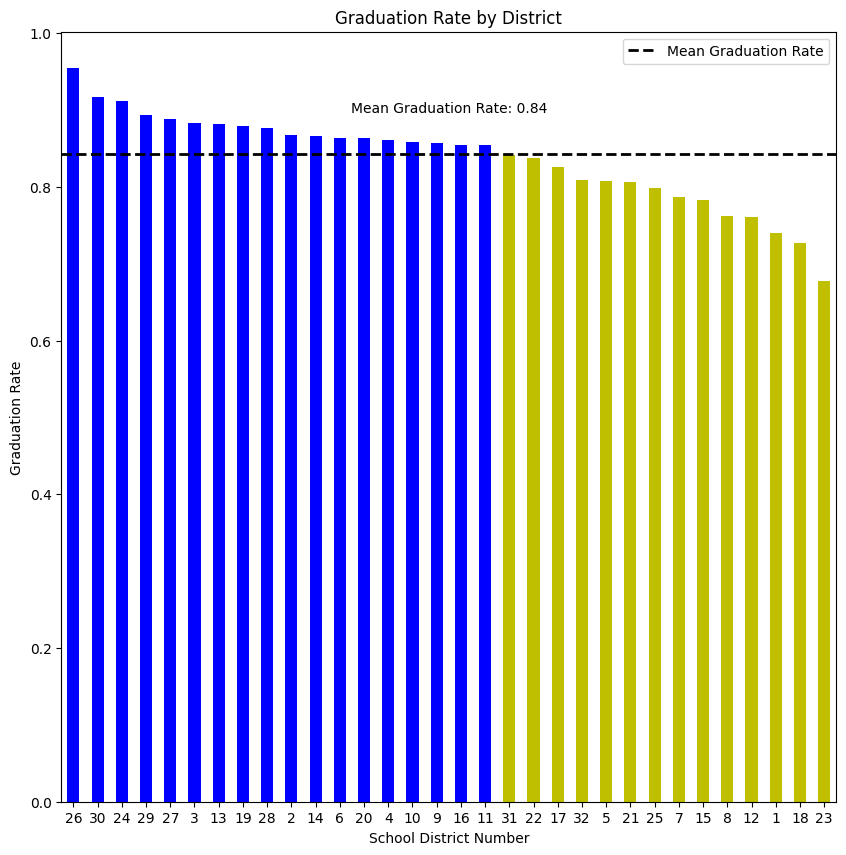

In [6]:
# Plot 1 - Bar Plot of Graduation Rate by District
plt.figure(figsize=(10,10)) 
plt.title('Graduation Rate by District')
# Add mean graduation rate to the plot
plt.axhline(graduation['graduation_Rate'].mean(), color='black', linestyle='dashed', linewidth=2)
plt.text(0.5, 0.9, 'Mean Graduation Rate: '+str(round(graduation['graduation_Rate'].mean(),2)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# Use gradual colours to show the graduation rate to the bars based on whether the graduation rate is above or below the mean and add a legend and show the colours as a gradient of different shades of red and blue
plt.legend(['Mean Graduation Rate', 'Above Mean', 'Below Mean'])
graduation.groupby('district_num')['graduation_Rate'].mean().sort_values(ascending=False).plot(kind='bar', color=graduation.groupby('district_num')['graduation_Rate'].mean().sort_values(ascending=False).apply(lambda x: 'b' if x>graduation['graduation_Rate'].mean() else 'y'))
plt.ylabel('Graduation Rate')
plt.xlabel('School District Number')
plt.xticks(rotation=0)
plt.show()

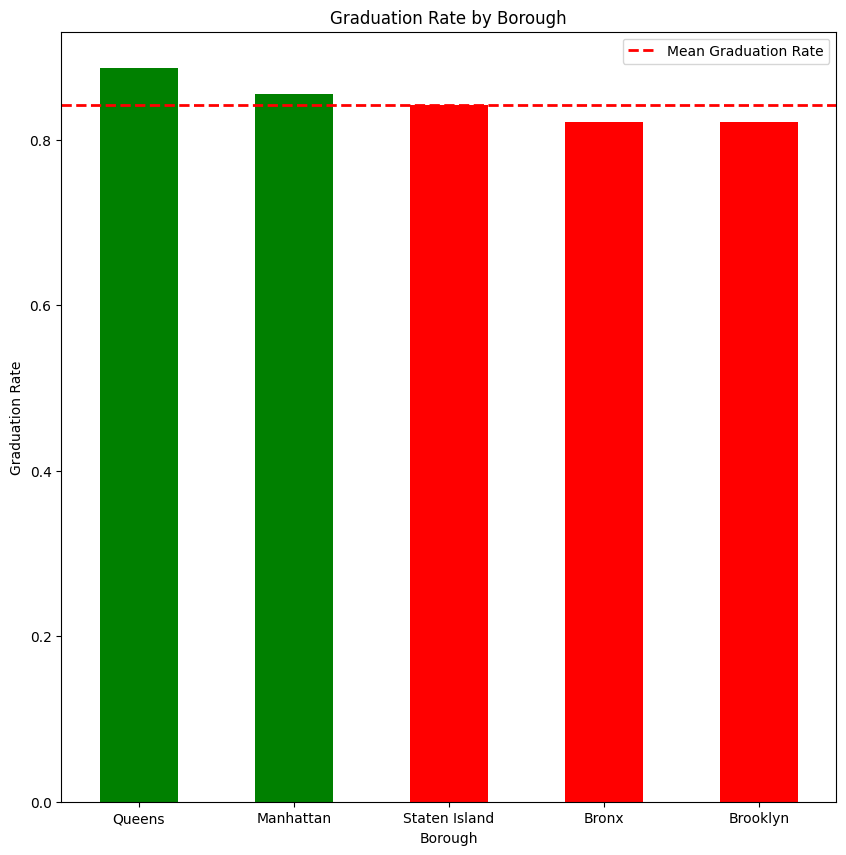

In [7]:
# Plot 2 - Map of Graduation Rate by Borough
plt.figure(figsize=(10,10))
plt.title('Graduation Rate by Borough')
plt.axhline(graduation['graduation_Rate'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.legend(['Mean Graduation Rate', 'Above Mean', 'Below Mean'])
graduation.groupby('district_borough')['graduation_Rate'].mean().sort_values(ascending=False).plot(kind='bar', color=graduation.groupby('district_borough')['graduation_Rate'].mean().sort_values(ascending=False).apply(lambda x: 'g' if x>graduation['graduation_Rate'].mean() else 'r'))
plt.xticks(rotation=0)
plt.xlabel('Borough')
plt.ylabel('Graduation Rate')
plt.show()

/var/folders/kc/qmz7hwmj24q4ycnfhfpqwbqh0000gn/T/ipykernel_4183/3047369026.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')
/Users/owenralbovsky/ORIE3120/venv/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


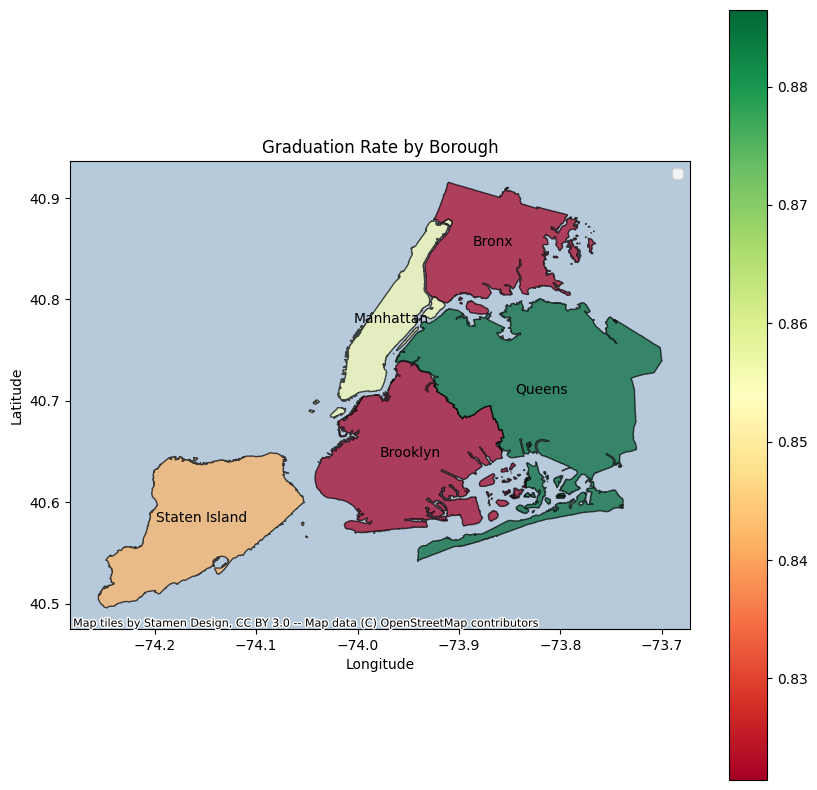

In [8]:
# Plot 3 - Map of Graduation Rate by Borough with color map
boroughs = gpd.read_file('Borough Boundaries/geo_export_600022ee-84a8-4aa6-89b8-38b32590367b.shp')
boroughs = boroughs.merge(graduation.groupby('district_borough')['graduation_Rate'].mean().reset_index(), left_on='boro_name', right_on='district_borough')
# Plot the map
fig, ax = plt.subplots(figsize=(10,10))
# Use colour blind friendly colour map
cmap = cm.get_cmap('RdYlGn')
boroughs.plot(column='graduation_Rate', cmap=cmap, ax=ax, legend=True, alpha=0.7, edgecolor='black')
# Add a title, axis labels and a legend
ax.set_title('Graduation Rate by Borough')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(['Graduation Rate'])
# Label the boroughs
for idx, row in boroughs.iterrows():
    ax.annotate(text=row['boro_name'], xy=row['geometry'].centroid.coords[0], horizontalalignment='center')
# Add a basemap
cx.add_basemap(ax, alpha = 0.7)
plt.show()

/var/folders/kc/qmz7hwmj24q4ycnfhfpqwbqh0000gn/T/ipykernel_4183/1025008958.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlGnBu')
/var/folders/kc/qmz7hwmj24q4ycnfhfpqwbqh0000gn/T/ipykernel_4183/1025008958.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(school_districts.geometry.centroid.x, school_districts.geometry.centroid.y, school_districts['district_num']):
/var/folders/kc/qmz7hwmj24q4ycnfhfpqwbqh0000gn/T/ipykernel_4183/1025008958.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation

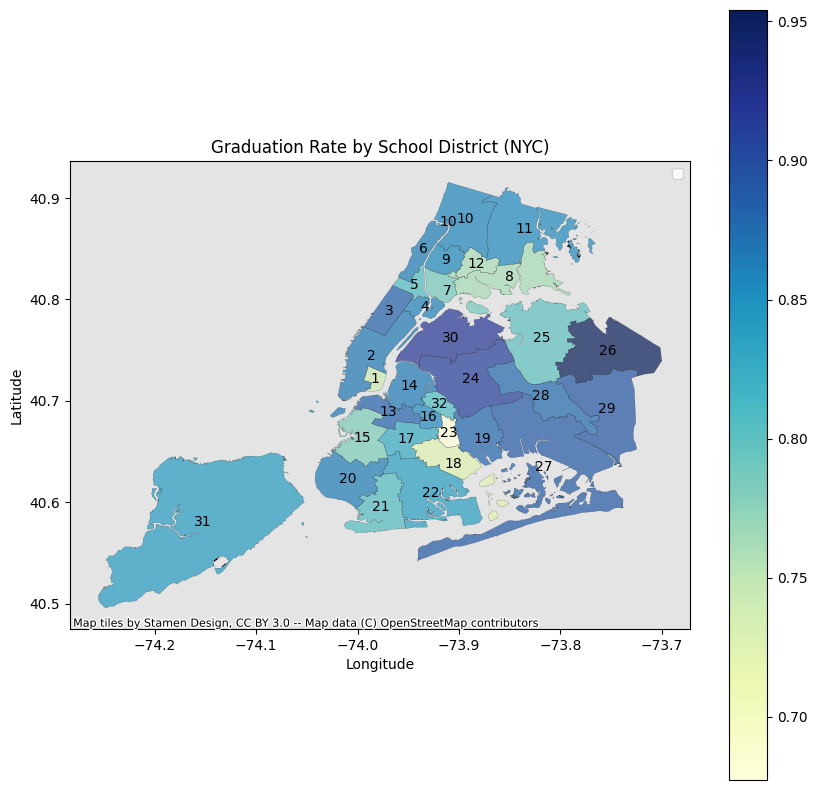

In [17]:

# Plot 4 - Map of Graduation Rate by School District
school_districts = gpd.read_file('School Districts/geo_export_6af67ebe-9ed2-44f1-acfa-20e6451b8842.shp')
graduation['district_num'] = graduation['district_num'].astype(float)
school_districts['school_dis'] = school_districts['school_dis'].astype(int)
school_districts = school_districts.merge(graduation.groupby('district_num')['graduation_Rate'].mean().reset_index(), left_on='school_dis', right_on='district_num')
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.cm.get_cmap('YlGnBu_r')
school_districts.plot(column='graduation_Rate', cmap=cmap, ax=ax, legend=True, alpha=0.7)
ax.set_title('Graduation Rate by School District (NYC)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(['Graduation Rate'])
# Add boundary lines
school_districts.boundary.plot(color=None, edgecolor='black', linewidth=0.1, ax=ax)
# Label the districts
for x, y, label in zip(school_districts.geometry.centroid.x, school_districts.geometry.centroid.y, school_districts['district_num']):
    # integer the label
    label = int(label)
    # Center the label
    ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points", ha='center', va='center')
# Add a basemap
cx.add_basemap(ax, alpha = 0.7, source=cx.providers.Stamen.TonerLite)
plt.show()

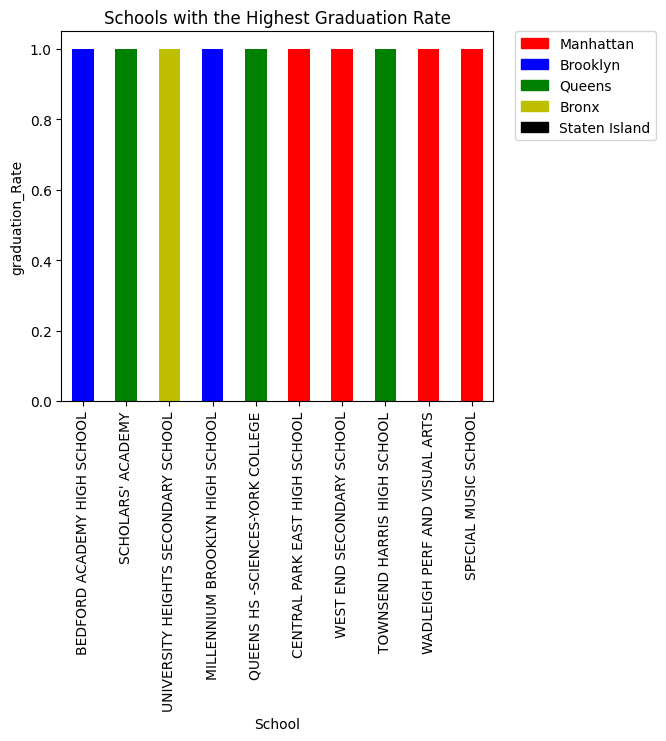

In [10]:
# Plot 5 - Bar Plot of schools with the highest graduation rate
graduation.sort_values(by='graduation_Rate', ascending=False).head(10).plot(kind='bar', x='School', y='graduation_Rate', color=graduation.sort_values(by='graduation_Rate', ascending=False).head(10)['district_borough'].apply(lambda x: 'r' if x=='Manhattan' else 'b' if x=='Brooklyn' else 'g' if x=='Queens' else 'y' if x=='Bronx' else 'k'))
plt.title('Schools with the Highest Graduation Rate')
plt.xlabel('School')
plt.ylabel('graduation_Rate')
legend = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
colors = ['r', 'b', 'g', 'y', 'k']
patches = [mpatches.Patch(color=colors[i], label=legend[i]) for i in range(len(legend))]
plt.subplots_adjust(right=0.8)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


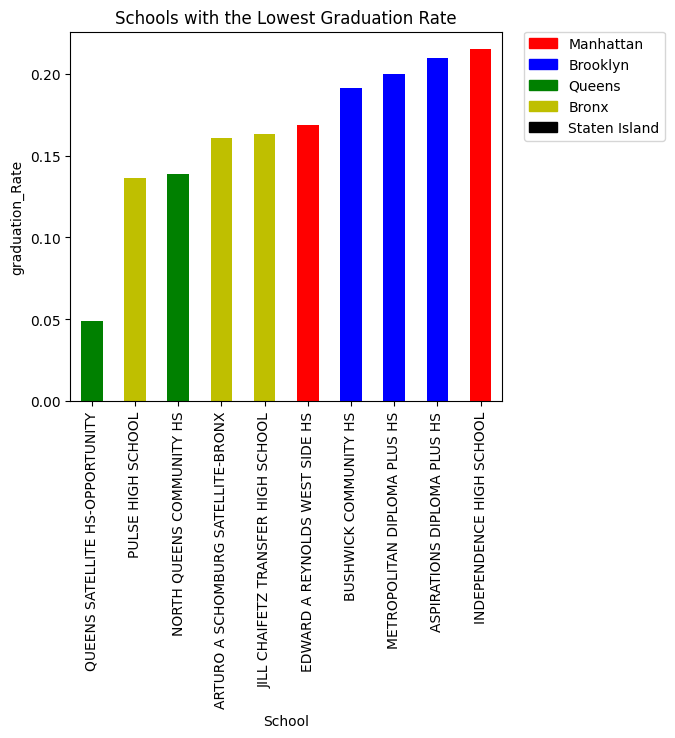

In [11]:
# Plot 6 - Bar Plot of schools with the lowest graduation rate
graduation.sort_values(by='graduation_Rate', ascending=True).head(10).plot(kind='bar', x='School', y='graduation_Rate', color=graduation.sort_values(by='graduation_Rate', ascending=True).head(10)['district_borough'].apply(lambda x: 'r' if x=='Manhattan' else 'b' if x=='Brooklyn' else 'g' if x=='Queens' else 'y' if x=='Bronx' else 'k'))
plt.title('Schools with the Lowest Graduation Rate')
plt.xlabel('School')
plt.ylabel('graduation_Rate')
legend = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
colors = ['r', 'b', 'g', 'y', 'k']
patches = [mpatches.Patch(color=colors[i], label=legend[i]) for i in range(len(legend))]
plt.subplots_adjust(right=0.8)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


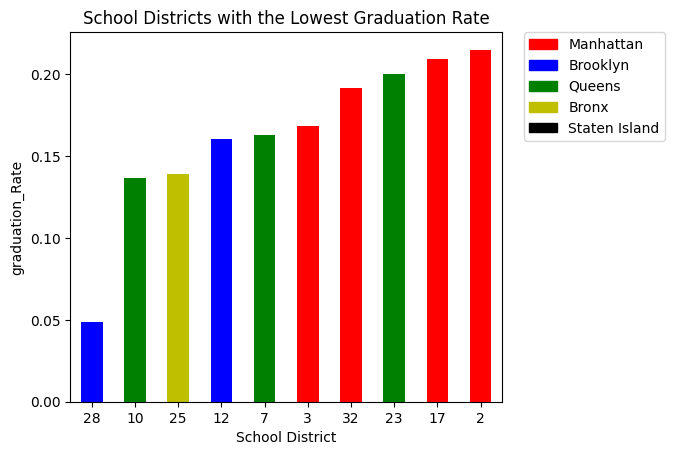

In [12]:
# Plot 7 - Bar Plot of school districts with the lowest quartile of graduation rate
graduation['district_num'] = graduation['district_num'].astype(int)
graduation.sort_values(by='graduation_Rate', ascending=True).head(10).plot(kind='bar', x='district_num', y='graduation_Rate', color=graduation.sort_values(by='graduation_Rate', ascending=False).head(10)['district_borough'].apply(lambda x: 'r' if x=='Manhattan' else 'b' if x=='Brooklyn' else 'g' if x=='Queens' else 'y' if x=='Bronx' else 'k'))
plt.title('School Districts with the Lowest Graduation Rate')
plt.xlabel('School District')
plt.ylabel('graduation_Rate')
legend = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
colors = ['r', 'b', 'g', 'y', 'k']
patches = [mpatches.Patch(color=colors[i], label=legend[i]) for i in range(len(legend))]
plt.subplots_adjust(right=0.8)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=0)
plt.show()


/var/folders/kc/qmz7hwmj24q4ycnfhfpqwbqh0000gn/T/ipykernel_4183/718062871.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


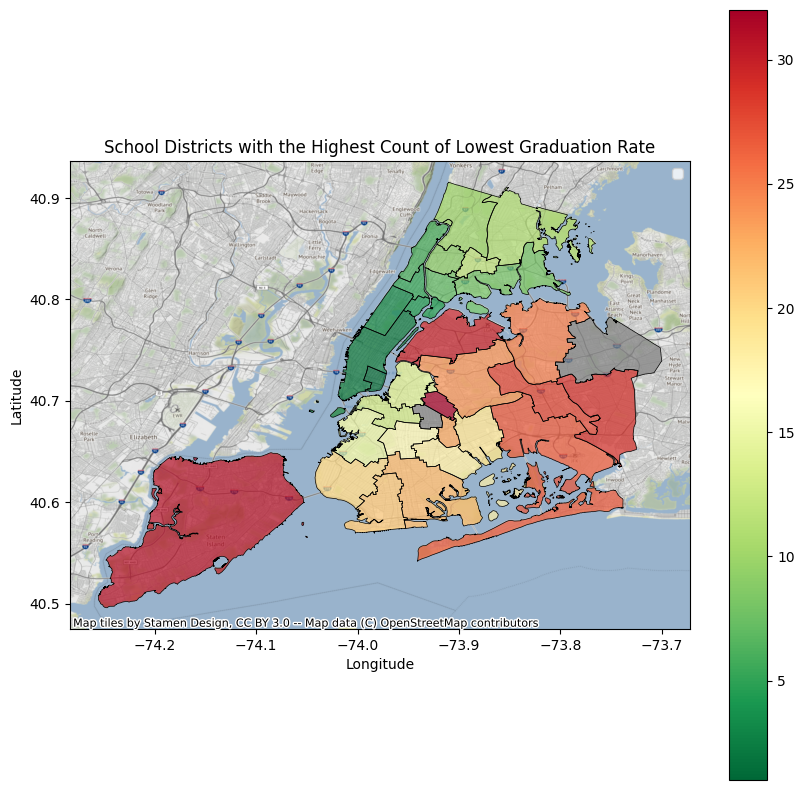

In [13]:
# Plot 8 - Map of school districts with the lowest quartile of graduation rate using GeoPandas using the below code as a reference
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.cm.get_cmap('RdYlGn')
cmap = cmap.reversed()
school_districts[school_districts['school_dis'].isin(graduation[graduation['graduation_Rate']<graduation['graduation_Rate'].quantile(0.25)]['district_num'])].plot(column='school_dis', cmap=cmap, ax=ax, legend=True, alpha=0.7)
school_districts[~school_districts['school_dis'].isin(graduation[graduation['graduation_Rate']<graduation['graduation_Rate'].quantile(0.25)]['district_num'])].plot(color='grey', ax=ax, alpha=0.7)
ax.set_title('School Districts with the Highest Count of Lowest Graduation Rate')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(['Number of Schools in the Lowest Quartile of Graduation Rate'])
# Add meaning of grey color in the legend
school_districts.boundary.plot(color=None, edgecolor='k', linewidth=0.5, ax=ax)
cx.add_basemap(ax, crs=school_districts.crs.to_string(), zoom=12)
plt.show()